## SI507 Final Project : Find Your Dream Home
#### Author: Deji Suolang

In [42]:
import pandas as pd
import numpy as np
import matplotlib as plot
import requests
import json
import os
import sys
import regex as re
import lxml
from bs4 import BeautifulSoup
import csv
import altair as alt
import altair_viewer
from IPython.display import display
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import nbimporter

import warnings
warnings.filterwarnings("ignore")

### Data Source 1: Census API 

In [43]:
# Caching
CACHE_FILENAME = 'cache.json'
CACHE_DICT = {}

In [44]:
def open_cache():
    ''' opens the cache file if it exists and loads the JSON into
    the FIB_CACHE dictionary.
    
    if the cache file doesn't exist, creates a new cache dictionary
    Parameters
    ----------
    None
    
    Returns
    -------
    The opened cache: dict
    '''
    try:
        cache_file = open(CACHE_FILENAME, 'r')
        cache_contents = cache_file.read()
        cache_dict = json.loads(cache_contents)
        cache_file.close()
    except:
        cache_dict = {}
    return cache_dict


# converts the dictionary to JSON and saves it
def save_cache(cache_dict):
    ''' saves the current state of the cache to disk
    Parameters
    ----------
    cache_dict: dict
        The dictionary to save
    Returns
    -------
    None
    '''

    dumped_json_cache = json.dumps(cache_dict)
    fw = open(CACHE_FILENAME,"w")
    fw.write(dumped_json_cache)
    fw.close()

In [45]:
def get_census_data(url):
    '''this function will retrieve the median income data from Census API data
    attainment data
    '''
    if os.path.isfile('cache.json') and os.access('cache.json', os.R_OK):
        with open('cache.json', 'r', newline='') as cache_file:
            cache = json.load(cache_file)
            return cache

    else:
        cache = requests.get(url).text
        census_data = json.loads(cache)
        save_cache(census_data)
        return census_data

def clean_census_data(census_data):
    '''cleans data and use county as the index
    '''
    county_dict = {}

    for item in census_data:
        county_dict[item[3].lower()] = item[1]
        county_dict['county'] = 'median_income'
        
    return county_dict

### Data Source 2: Zillow Web Scraping

In [46]:
headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
    }

# We are intersted in the for sale home in the state of Michigan
base_url = "https://www.zillow.com/homes/for_sale/"
state = 'mi'

def makesoup(data):
    with requests.Session() as s:
        r = s.get(data, headers=headers)
        soup = BeautifulSoup(r.content, 'html.parser')
    return soup

def get_zillow_results(data):
    '''obtain useful variables from zillow scrapping results'
    '''
    address = data.find_all(class_= 'list-card-addr')
    price = list(data.find_all(class_='list-card-price'))
    bed_num = list(data.find_all("ul", class_="list-card-details"))
     #create dataframe columns out of variables
    df['prices'] = price
    df['address'] = address
    df['bed_num'] = bed_num
    return df.copy()

def get_url_list(base_url, state):
    url_list = []
    url_list.append(base_url +state+'/')
    for i in range(2,26):
        domain = base_url + state +'/'+str(i)+'_p/'
        url_list.append(domain)
    return url_list

def create_soup_list(url_list):
    soup_list = []
    for url in url_list:
        htmls = makesoup(url)
        soup_list.append(htmls)
    return soup_list

def create_dataframe_list(soup_list):
    df_list = []
    for soup in soup_list:
        new_df = get_zillow_results(soup)
        df_list.append(new_df)
    return df_list

def clean_zillow_data(df_list):
    zillow_df = pd.concat(df_list)
    zillow_df.reset_index(inplace=True)
    zillow_df = zillow_df.drop('index', axis=1)
    zillow_df = zillow_df.applymap(str)
    zillow_df = zillow_df.applymap(lambda x: re.sub('<[^<]+?>', '',x))
    zillow_df[['bed_num', 'home_type']] = zillow_df.bed_num.str.split('-',n=1, expand=True)
    zillow_df[['address', 'city','zip_code']] = zillow_df.address.str.split(",", expand=True)
    # separate bed_num column into bed, bath, and sq_feet
    zillow_df[['bed_num', 'baths', 'sqft']] = zillow_df.bed_num.str.split(' ',n=2, expand=True)
    zillow_df['sqft'] = zillow_df.sqft.str.replace(",", "")
    # extract only the digits from the columns
    zillow_df['bed_num'] = zillow_df.bed_num.str.extract('(\d+)')
    zillow_df['baths'] = zillow_df.baths.str.extract('(\d+)')
    zillow_df['sqft'] = zillow_df.sqft.str.extract('(\d+)')
    # convert columns to float
    zillow_df['bed_num'] = zillow_df['bed_num'].astype('float')
    zillow_df['baths'] = zillow_df['baths'].astype('float')
    zillow_df['sqft'] = zillow_df['sqft'].astype('float')
    zillow_df[['state', 'zipcode']] = zillow_df.zip_code.str.split(expand=True)
    zillow_df['zipcode'] = zillow_df['zipcode'].astype(str)
    zillow_df['prices'] = zillow_df['prices'].str.strip("$")
    zillow_df['prices'] = zillow_df['prices'].str.replace("K","")
    zillow_df['prices'] = zillow_df['prices'].str.replace(",","")
    zillow_df['prices'] = zillow_df['prices'].astype('float')
    zillow_df = zillow_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    return zillow_df

In [48]:
if __name__ == "__main__":
    # Calling Census functions
    census_data = get_census_data("https://api.census.gov/data/2019/acs/acs5?get=NAME,B19013_001E&for=tract:*&in=state:26&key=dfdb2a1eda26b816e1c7d71114a341b40b1b40b4")
    census_data = clean_census_data(census_data)
    with open('census_data.csv', 'w') as f:
        [f.write('{0},{1}\n'.format(key, value)) for key, value in census_data.items()]

    # Calling Census functions
    url_list = get_url_list(base_url, state)
    soup_list = create_soup_list(url_list)
    df = pd.DataFrame()
    zillow_df = pd.DataFrame()
    df_list = create_dataframe_list(soup_list)
    zillow_df = clean_zillow_data(df_list)

    # Crosswalk
    zip_county_crosswalk = pd.read_csv('zip_county_crosswalk.csv')
    zip_county_crosswalk['zipcode'] = zip_county_crosswalk['zipcode'].astype(str)
    zip_county_crosswalk['county'] = zip_county_crosswalk['county'].astype(str)
    zip_county_crosswalk = zip_county_crosswalk.drop_duplicates(subset =['zipcode'],keep="first")
    zillow_df = pd.merge(zillow_df, zip_county_crosswalk, how='left', on='zipcode')
    zillow_df.to_csv('zillow_data.csv')

    # Merge census data and zillow data
    census_data = pd.read_csv('census_data.csv')
    census_data['county'] = census_data['county'].astype(str)
    census_data['median_income'] = np.where(census_data['median_income'].astype(str) == "-666666666", 'NA', census_data['median_income'])
    proj_data = zillow_df.merge(census_data, how='left', on='county')
    proj_data.to_csv('project_data.csv')
    proj_data.head()

In [7]:
#### Tree Graph
##### Chracterisctics of the real estate that determine whether the home value is above or under the state average

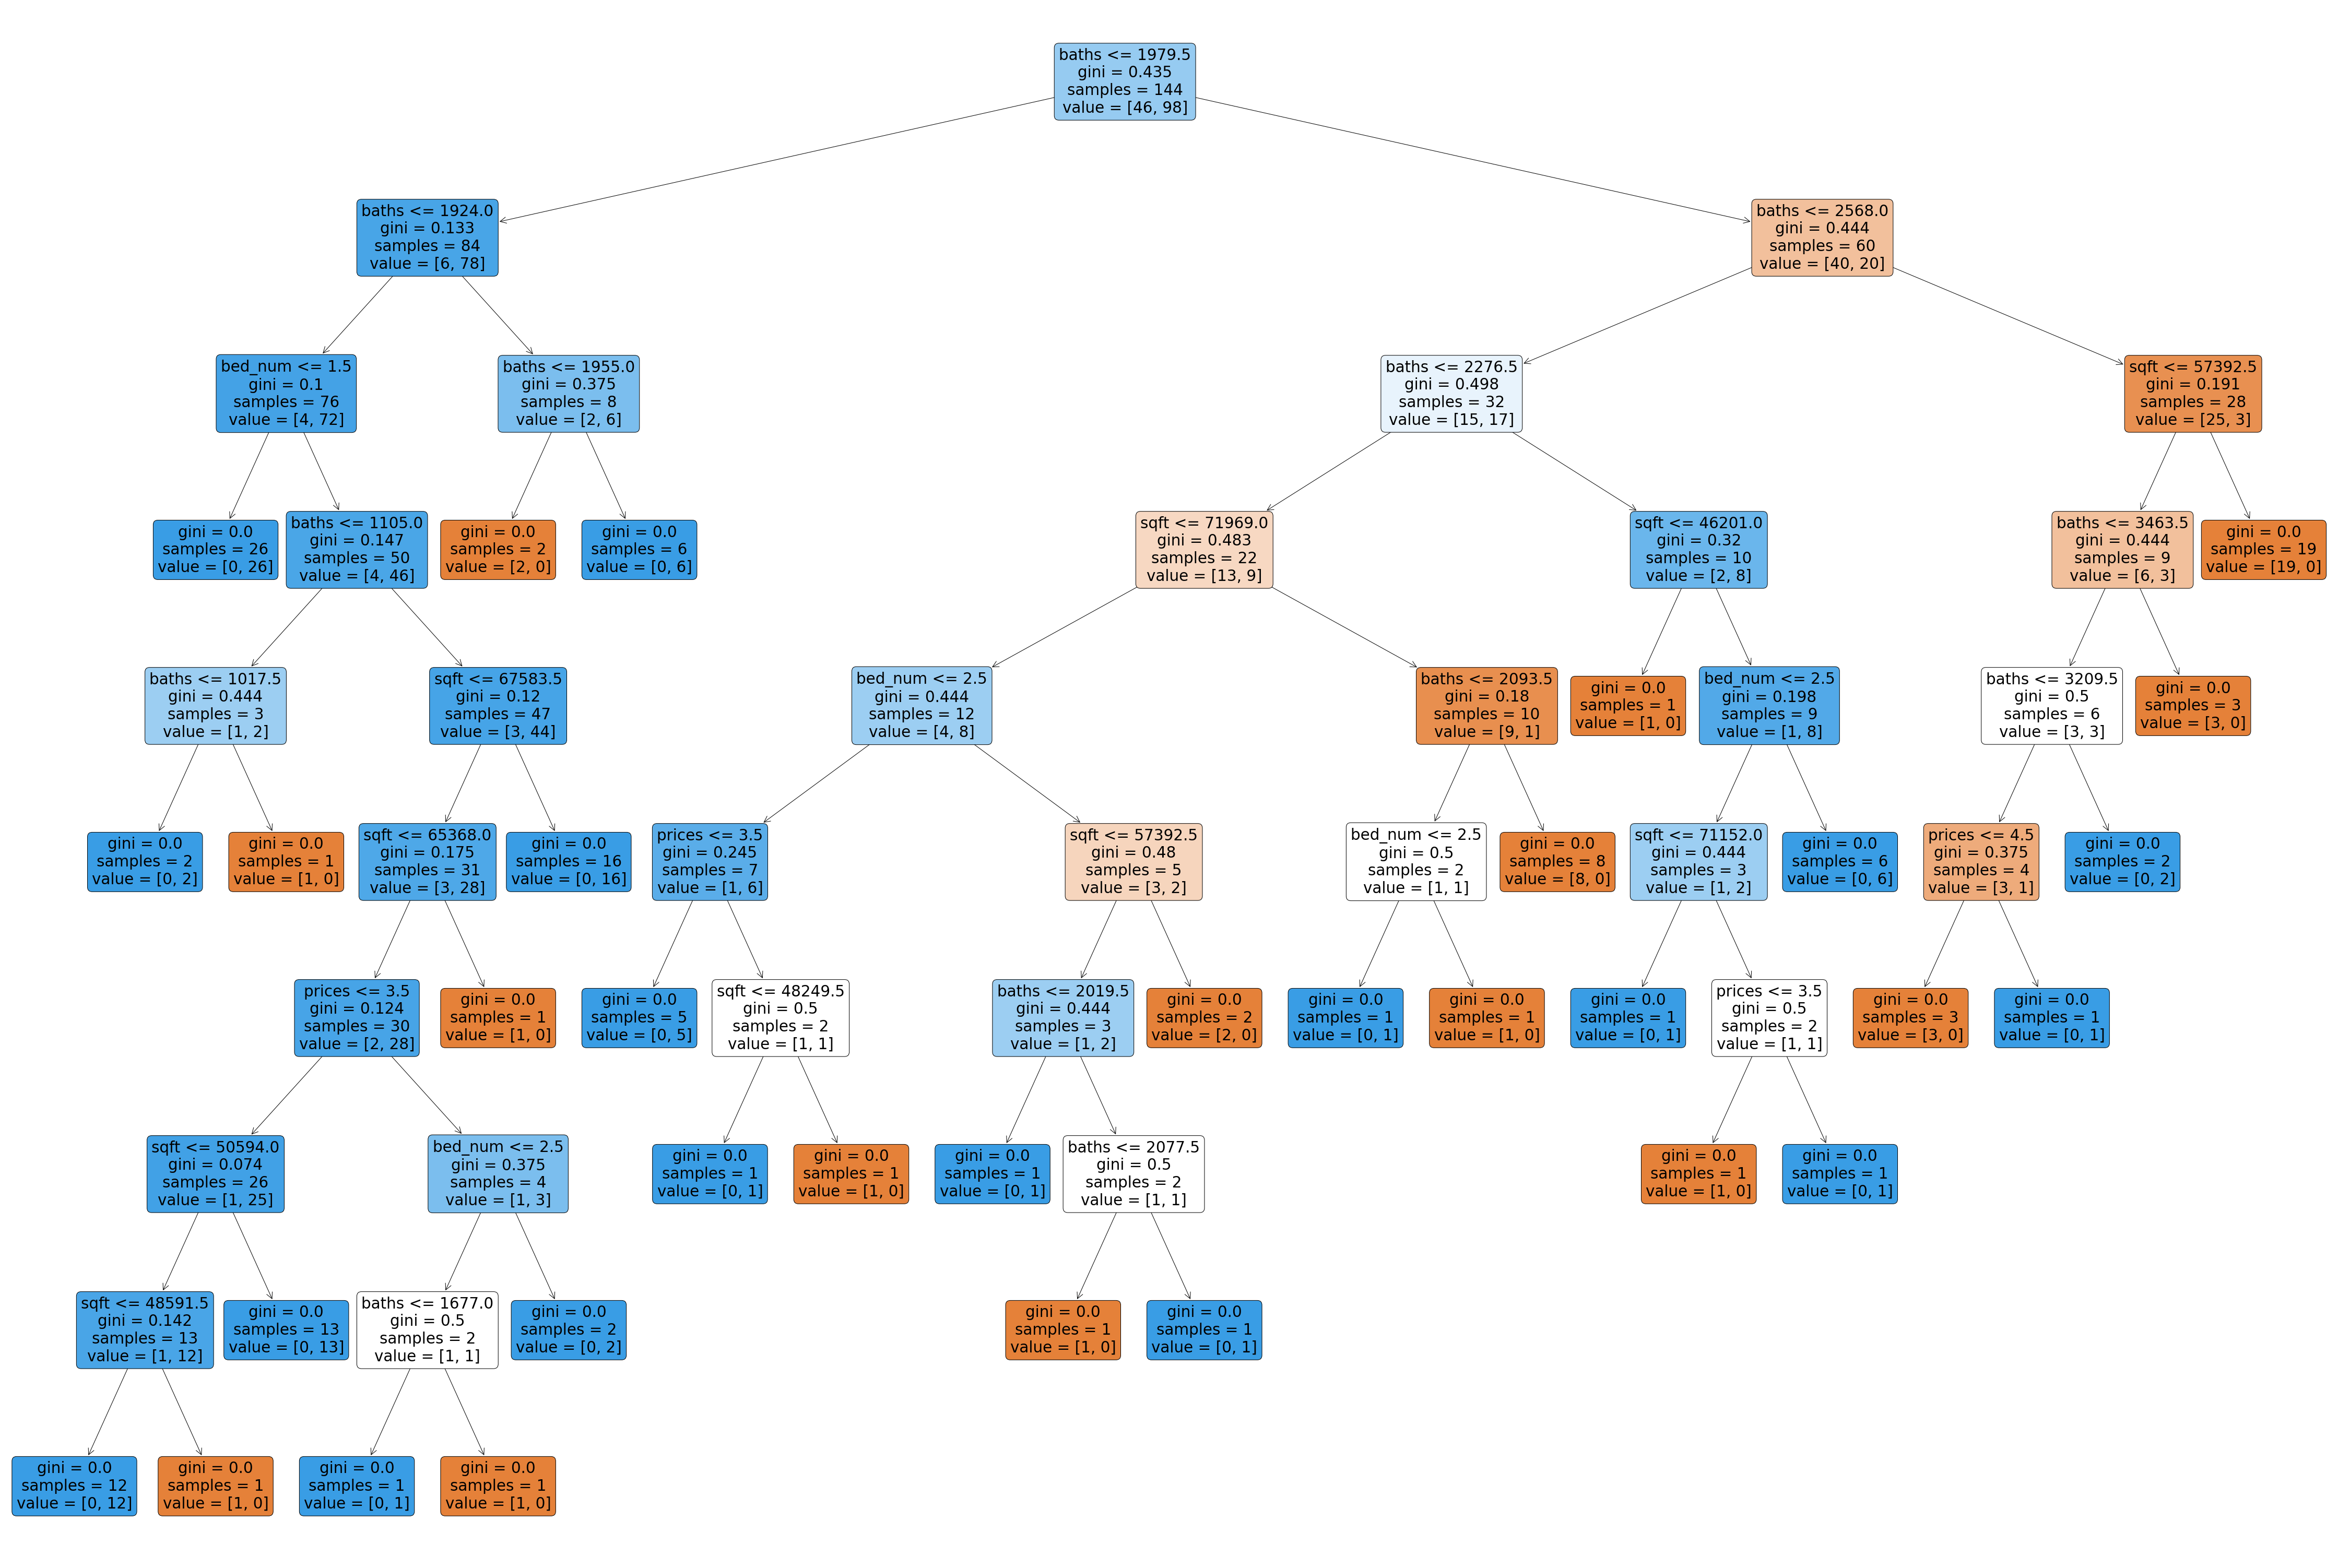

In [8]:
%run tree.ipynb


#### Interaction and Presentation

In [81]:
def welcome_page():
    '''
    Welcome users to the interactive console
    '''
    print(f"\nWelcome to the 'Find Your Dream Home' project. This project explores real estate data in Michigan and will help you make informed decision when buying a home.")

def interaction_options():
    print('-' * 100)
    print(f"1. See all home for sale listing in your city")
    print(f"2. Search home for sale by number of rooms")
    print(f"3. Search home for sale by squarefeet")
    print(f"4. Find an affordable home within your budget")
    print(f"5. Compare the average housing price across different cities in Michigan")
    print(f"6. Correlation between different aspects of home")
    print(f"7. Search for cities has top neighborhoods, highest median household income")
    print(f"8. Check housing price range for differnt floor plans")
    
def listing_by_city(city, df):
    df['city'] = df['city'].str.lower()
    if city.lower() in df.values:
        results = df[df['city'] == city.lower()] 
        return results
    else:
        return 'No research results'
    
def listing_by_roomnum(bed_num, baths, df):
    results = df.loc[(df['bed_num'] == bed_num) & (df['baths'] == baths)]
    results = results[["prices", "address","bed_num","baths","home_type","city","zip_code","sqft","county", "median_income"]]
    if len(results) == 0:
        return 'No research results'
    else :
        return results
    
def listing_by_squarefeet(squarefeet,num_results, df):
    results = df.loc[(df['sqft'] >=squarefeet)]
    results = results[["prices", "address","bed_num","baths","home_type","city","zip_code","sqft","county", "median_income"]]
    if len(results) == 0:
        return 'No research results'
    elif len(results) < num_results:
        print('There are less results than you requested')
        return results
    else :
        return results.sample(num_results)
    
def listing_by_budget(budget,num_results, df):
    df['prices'] = df['prices'].astype(float)
    results = df.loc[(df['prices'] <= budget)]
    results = results[["prices", "address","bed_num","baths","home_type","city","zip_code","sqft","county", "median_income"]]
    if len(results) == 0:
        return 'No research results'
    elif len(results) < num_results:
        print('There are less results than you requested')
        return results
    else:
        return results.sample(num_results)

In [2]:
if __name__ == "__main__":
    welcome_page()
    proj_data = pd.read_csv('project_data.csv')
    while True:
        interaction_options()
        # Select interactive option
        option = input(f"\nPlease type one of the option numbers to start (e.g. '1') or 'exit': ")
        option_input = option.lower().strip()
        # Exit
        if option_input == 'exit':
            print(f'\nBye!')
            break
        #Option 1: See all home for sale listing in your city
        elif option_input == '1':
            while True:
                city_input = input(f"\nPlease enter the city where you are looking to buy a home or 'exit': ")
                if city_input !='exit':
                    results = listing_by_city(city=city_input, df=proj_data)
                    results= results[["prices", "address", "bed_num","baths","home_type", "city", "zip_code", "sqft", "county", "median_income"]]
                    display(results)
                else:
                    print(f'\nBye!')
                    break
                print('-' * 100) 
        #Option 2: Search home for sale by number of rooms
        elif option_input == '2':
            while True:
                bednum_input = input(f"\nPlease enter the number of bedrooms you need or 'exit': ")
                baths_input = input(f"\nPlease enter the number of bathrooms you need or 'exit': ")
                if bednum_input =='exit' or baths_input =='exit':
                    print(f'\nBye!')
                    break
                else:
                    try:
                        bednum_input = int(bednum_input)
                        baths_input = int(baths_input)
                        results = listing_by_roomnum(bed_num = bednum_input, baths = baths_input, df=proj_data)
                        results= results[["prices", "address", "bed_num","baths","home_type", "city", "zip_code", "sqft", "county", "median_income"]]
                        display(results)
                    except ValueError:
                        print("Oops!  This is not a valid number.  Try again")
                print('-' * 100)
        # Option 3: Search home for sale by squarefeet
        elif option_input == '3':
            while True:
                squarefeet_input = input(f"\nPlease enter the minimum size of the house (squarefeet) or 'exit': ")
                num_results = input(f"\nPlease enter the number of the results you want to view or 'exit': ")
                if squarefeet_input =='exit':
                    print(f'\nBye!')
                    break
                else:
                    try:
                        squarefeet_input = int(squarefeet_input)
                        num_results = int(num_results)
                        results = listing_by_squarefeet(squarefeet=squarefeet_input, num_results=num_results, df=proj_data)
                        results= results[["prices", "address", "bed_num","baths","home_type", "city", "zip_code", "sqft", "county", "median_income"]]
                        display(results)
                    except ValueError:
                        print("Oops!  This is not a valid number.  Try again...")
                print('-' * 100)
        # Option 4: Find an affordable home within your budget
        elif option_input == '4':
            while True:
                budget_input = input(f"\nPlease enter your budget($) or 'exit': ")
                num_results = input(f"\nPlease enter the number of the results you want to view or 'exit': " )
                if budget_input =='exit':
                    print(f'\nBye!')
                    break
                else:
                    try:
                        budget_input = float(budget_input)
                        num_results = int(num_results)
                        results = listing_by_budget(budget=budget_input, num_results=num_results, df=proj_data)
                        results= results[["prices", "address", "bed_num","baths","home_type", "city", "zip_code", "sqft", "county", "median_income"]]
                        display(results)
                    except ValueError:
                        print("Oops!  This is not a valid number.  Try again...")
                print('-' * 100)
                
        # Option 5: Compare the average housing price across different cities in Michigan
        elif option_input == '5':
            while True:
                bars= alt.Chart(proj_data,width=700).mark_bar().encode(
                    x=alt.X('mean(prices)'),
                    y=alt.Y('city',
                            sort =alt.EncodingSortField(
                                field='prices',op='mean',order="descending"
                            )
                           )
                )
                text = bars.mark_text(
                    align='left',
                ).encode(
                    text='mean(prices)'
                )
                vis1 = bars + text
                vis1.show()
                break
                
        # Option 6: Correlation between different aspects of home
        elif option_input == '6':
            data_subset= proj_data[["prices", "bed_num","baths","sqft","median_income"]]
            vis2 = sns.heatmap(data_subset.corr(),cmap="BuPu",annot=True)
            vis2
            break
                        
        # Option 7: Search for a home located in top neighberhoods, cities with highest median hosuehold income.
        elif option_input == '7':
            proj_data['median_income_quantile'] = (
                pd.qcut(proj_data['median_income'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
            )
            data_subset = proj_data[proj_data['median_income_quantile'] == 'Q4'] 
            text = " ".join(review for review in data_subset.city.astype(str))
            vis3 = WordCloud(background_color="white", stopwords = ['township', 'Heights'], width=800, height=400).generate(text)
            plt.imshow(vis3, interpolation='bilinear')
            plt.show()
            break

        # Option 8: Check average housing price range for differnt floor plans in your city(number of rooms)
        elif option_input == '8':
            while True:
                city_input = input(f"\nPlease enter the city where you are looking to buy a home or 'exit': ")
                if city_input !='exit':
                    results = listing_by_city(city=city_input, df=proj_data)
                    results['total_room_number'] = results['bed_num'] + results['baths']
                    results['total_room_number'] = pd.Categorical(results.total_room_number)
                    data_subset = results.dropna()
                    vis4= alt.Chart(results,width=500).transform_filter(
                        alt.datum.total_room_number >0 and alt.datum.total_room_number <12
                    ).mark_bar().encode(
                        y=alt.Y('mean(prices)'),
                        x=alt.X('total_room_number'
                               )
                    )
                    vis4.show()
                else:
                    print(f'\nBye!')
                    break